# 0. Import package

In [1]:
import os
import cv2
import json
import umap
import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from torchvision import datasets, transforms
from scipy.stats import differential_entropy, norm

# 1. Load data of the base model

## 1-1. Stimulus

In [4]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def get_stimulus_path(model_nickname):
    return f'/raid/NeuEvo/data/stimulus/{model_nickname}/data/stimulus-topk_s=20.json'

In [91]:
img_emb_p = '/raid/NeuEvo/data/embedding/_etc/_old/vgg19_pretrained/data/img_emb-dim=30-lr_img_emb=10.0-thr_img_emb=0.001-max_iter_img_emb=10000-k=10.txt'
X_i = np.loadtxt(img_emb_p)
num_imgs = len(X_i)

In [102]:
base_stimulus = load_json(get_stimulus_path('vgg19_pretrained'))

In [10]:
base_vocab = {}
for layer in base_stimulus:
    for neuron_idx, imgs in enumerate(base_stimulus[layer]):
        for img in imgs:
            if img not in base_vocab:
                base_vocab[img] = 0
            base_vocab[img] += 1

num_covered_imgs = len(base_vocab)
print(f'{num_covered_imgs} imgs are covered ({num_covered_imgs / num_imgs * 100:.2f})%')

56475 imgs are covered (4.41)%


## 1-2. Neuron embedding

In [39]:
def draw_scatter(Xs, title=None, Xs_highlight=None):
    X = Xs[:, 0]
    Y = Xs[:, 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(X, Y, s=5, alpha=0.2, color='gray')
    if title is not None:
        plt.title(title)
    if Xs_highlight is not None:
        X = Xs_highlight[:, 0]
        Y = Xs_highlight[:, 1]
        plt.scatter(X, Y, s=20, alpha=1, color='blue')
    plt.show() 

In [40]:
p = '/raid/NeuEvo/data/embedding/emb-vgg19_pretrained-topk_s=20-dim=30-lr_emb=0.05-num_emb_epochs=10000-num_emb_negs=3/data/emb/emb.json'
n_emb = load_json(p)
num_neurons = len(n_emb)

In [92]:
neuron_id2idx = {}
neuron_idx2id = {}
X_base_n = np.zeros((num_neurons, 30))
for neuron_i, neuron in enumerate(n_emb):
    X_base_n[neuron_i] = n_emb[neuron]
    neuron_id2idx[neuron] = neuron_i
    neuron_idx2id[neuron_i] = neuron

In [93]:
reducer = umap.UMAP(n_components=2)
reducer = reducer.fit(X_base_n)
X_base_n_2d = reducer.embedding_

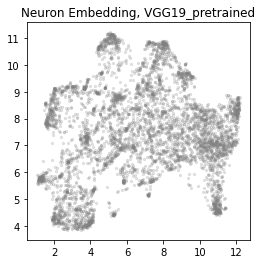

In [94]:
draw_scatter(
    X_base_n_2d, 
    title="Neuron Embedding, VGG19_pretrained", 
)

## 1-3. Projected neuron embedding

In [96]:
def gen_avg_img_vec(imgs, X_i, dim):
    avg_v = np.zeros(dim)
    for img in imgs:
        avg_v += X_i[img]
    avg_v /= len(imgs)
    return avg_v

In [103]:
X_base_p = np.zeros((num_neurons, dim))
for neuron_i in range(num_neurons):
    neuron_id = neuron_idx2id[neuron_i]
    layer, neuron_idx = neuron_id.split('-')
    neuron_idx = int(neuron_idx)
    imgs = base_stimulus[layer][neuron_idx]
    X_base_p[neuron_i] = gen_avg_img_vec(imgs, X_i, dim)

In [104]:
X_base_p_2d = reducer.transform(X_base_p)

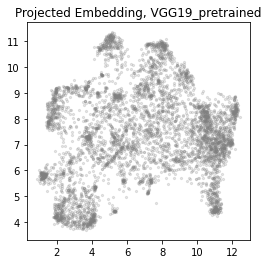

In [105]:
draw_scatter(
    X_base_p_2d, 
    title="Projected Embedding, VGG19_pretrained", 
)

# 2. Load data of a test model (ConvNeXt @ epoch 96)

## 2-1. Load stimulus

In [38]:
model_nickname = 'convnext_0.004_96'
convnext_stimulus = load_json(get_stimulus_path(model_nickname))

## 2-2. Show an example of a neuron

### 2-2-1. Select a neuron

In [77]:
convnext_stimulus.keys()

dict_keys(['features_1_blk_0', 'features_1_blk_1', 'features_1_blk_2', 'features_2_blk_0', 'features_2_blk_1', 'features_3_blk_0', 'features_3_blk_1', 'features_3_blk_2', 'features_4_blk_0', 'features_4_blk_1', 'features_5_blk_0', 'features_5_blk_1', 'features_5_blk_2', 'features_5_blk_3', 'features_5_blk_4', 'features_5_blk_5', 'features_5_blk_6', 'features_5_blk_7', 'features_5_blk_8', 'features_6_blk_0', 'features_6_blk_1', 'features_7_blk_0', 'features_7_blk_1', 'features_7_blk_2'])

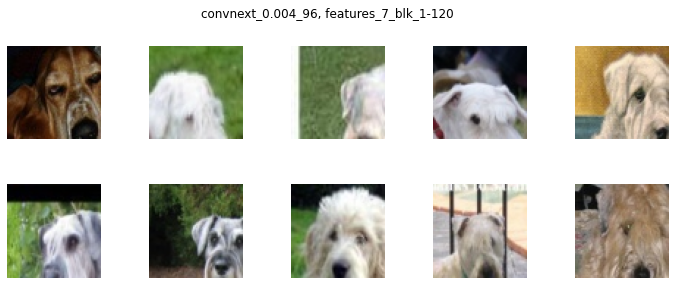

In [238]:
model_nickname = 'convnext_0.004_96'
layer = 'features_7_blk_1'
neuron_idx = 120
show_ex_patchs(model_nickname, layer, neuron_idx)

### 2-2-2. Show example patches of the selected neuron

In [46]:
def get_ex_patch_paths(model_nickname, layer, neuron_idx):
    topk_s = 20
    if 'vgg19' in model_nickname:
        topk_s = 15
        
    paths = []
    dir_path = f'/raid/NeuEvo/data/neuron_feature/{model_nickname}/data/topk_s={topk_s}-ex_patch_size_ratio=0.3'
    for i in range(10):
        p = os.path.join(dir_path, f'{layer}-{neuron_idx}-{i}.jpg')
        paths.append(p)
        
    return paths

def show_ex_patchs(model_nickname, layer, neuron_idx):
    paths = get_ex_patch_paths(model_nickname, layer, neuron_idx)
    imgs = []
    for path in paths:
        img = load_img_from_path(path)
        imgs.append(img)
    show_np_imgs_2_rows(imgs, title=f'{model_nickname}, {layer}-{neuron_idx}')
    
def load_img_from_path(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()

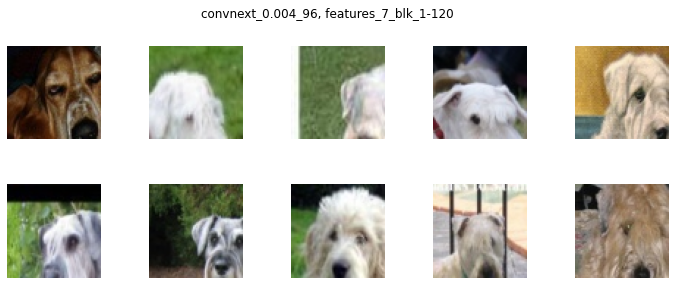

In [239]:
show_ex_patchs(model_nickname, layer, neuron_idx)

### 2-2-3. Show stimulus of the neuron

In [33]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

def show_training_imgs_2_rows(img_idxs):
    imgs = []
    subplot_titles = []
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'img: {img_idx}')
    show_np_imgs_2_rows(imgs)

stimulus: [253145, 292975, 289829, 253270, 243387, 330934, 243484, 256409, 272018, 243533, 271963, 207860, 258328, 259835, 292572, 270803, 242797, 258159, 271827, 258906]

These images are covered 0 time(s) in the vocab:
[253145, 292975, 289829, 253270, 243387, 330934, 243484, 272018, 243533, 271963, 207860, 258328, 259835, 292572, 270803, 242797, 258159, 271827, 258906]


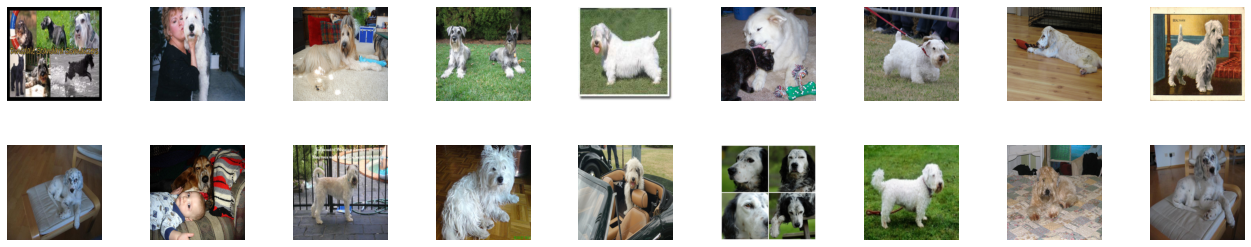

These images are covered 1 time(s) in the vocab:
[256409]


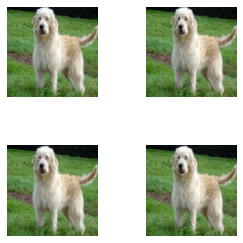

In [240]:
print(f'stimulus: {convnext_stimulus[layer][neuron_idx]}\n')

coverage = {}
for img in convnext_stimulus[layer][neuron_idx]:
    cnt = 0
    if img in base_vocab:
        cnt = base_vocab[img]
    if cnt not in coverage:
        coverage[cnt] = []
    coverage[cnt].append(img)

for cnt in coverage:
    print(f'These images are covered {cnt} time(s) in the vocab:')
    print(coverage[cnt])
    if len(coverage[cnt]) < 4:
        show_training_imgs_2_rows(coverage[cnt] * 4)
    else:
        show_training_imgs_2_rows(coverage[cnt])

### 2-2-4. Show the covered image (in the stimulus) on the semantic space

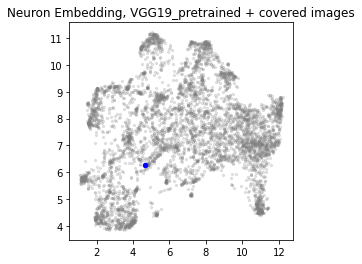

In [241]:
imgs = []
for cnt in coverage:
    if cnt > 0:
        imgs = imgs + coverage[cnt]
        
Xs_highlight_2d = np.zeros((len(imgs), 2))
for i, img in enumerate(imgs):
    X = reducer.transform([X_img[img]])
    Xs_highlight_2d[i] = X[0]
    
draw_scatter(
    X_base_n_2d, 
    title="Neuron Embedding, VGG19_pretrained + covered images", 
    Xs_highlight=Xs_highlight_2d
)